In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



# Machine Learning Project - 
# Wiederholte Fragen
### David Brand, Max Hampel




## Aufgabenstellung


> Die Datensammlung enthält Fragen aus einem Forum. Es sind Paare aus Fragen gleichen Inhalts geboten.
>  Erstellen Sie ein tiefes Neuronales Netzwerk, dass dem Nutzer schon bei der Eingabe einer neuen Frage gleich ähnliche Fragen anbietet.
>  - Je mehr Text der Benutzer eingibt, desto präziser sollen die ähnlichen Fragen sein!


## Bereitgestellte Daten

Bereitgestellter Datensatz besteht aus:
 - README-Datei
 - Traningsdatensatz(train.csv)
 - Validierungsdatensatz(test.csv)
 - sample_submission.csv
 

In [14]:
df_train = pd.read_csv(
    "./fragen/train.csv",
    encoding = 'utf-8'
)

df_test = pd.read_csv(
    "./fragen/test.csv",
    usecols= ['test_id', 'question1', 'question2'],
    encoding = 'utf-8',
    dtype=object
)

df_submission = pd.read_csv(
    "./fragen/sample_submission.csv",
    encoding='utf-8',
    dtype=object
    
)


### Trainingsdatensatz

In [15]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


- ca. 404.000 Einträge


**Einzelne Einträge bestehen aus:**

- id: Einzigartige Nummer für den Eintrag
- qid1,qid2: Eintragene Nummer, die für jede Frage einzigartig
- question1,question 2: Tatsächlicher Text der jeweiligen Frage
- is_duplicate: Sind beide Fragen miteinander verwandt, oder nicht?
    - 0: nicht verwandt
    - 1: verwandt
 

**Verteilung der Klassen:**


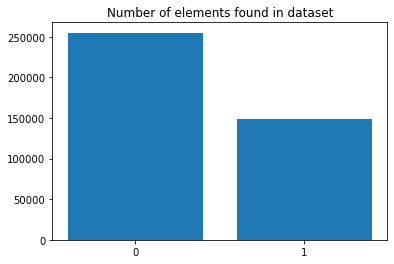

In [16]:
fig, ax = plt.subplots()
label_dist = df_train.is_duplicate.value_counts()

ax.bar([0,1],label_dist)
ax.set_xticks([0,1], labels=[0,1])
ax.set_title('Number of elements found in dataset')
plt.show()

### Testdatensatz

- Über die Dateien test.csv und sample_submission.csv verteilt
  -> Müssen zusammengeführt werden
- ca. 2,3 Millionen Fragepaarungen


In [17]:
# test.csv:
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [18]:
# sample_submission.csv:
df_submission.head()

,test_id,is_duplicate
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [19]:
# Zusammenfügen beider Datensätze
df_test_merged = df_test.merge(df_submission, left_on="test_id", right_on="test_id")

df_test_merged.dropna(inplace=True)
df_test_merged.drop_duplicates(inplace=True)

h1=df_test_merged.is_duplicate.value_counts()
label_dist2 = np.array([df_test_merged.is_duplicate.value_counts(),0], dtype=object)

In [20]:
df_test_merged.head()

,test_id,question1,question2,is_duplicate
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...,1
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?,1
2,2,What but is the best way to send money from Ch...,What you send money to China?,1
3,3,Which food not emulsifiers?,What foods fibre?,1
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?,1


**Verteilung der Labels**

In [21]:
print(df_test_merged.is_duplicate.value_counts())

1    2345790
Name: is_duplicate, dtype: int64


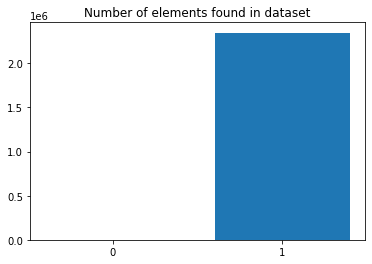

In [23]:
fig, ax = plt.subplots()
ax.bar([1,0],label_dist2)
ax.set_xticks([0,1], labels=[0,1])
ax.set_title('Number of elements found in dataset')
plt.show()

## Idee für das Modell

Erstellen eines Klassifizieres, der zwei Fragen als Input bekommt.
   - Training: Input sind question1 und question 2, sowie is duplicate.
   - Spätere Vorhersage: Eingegebener Text des Users und Iterrieren über Datensatz, um möglichst ähnliche Fragen zu finden.
   - seq2seq Model erzielte bei erstem Test deutlich geringere Accuracy
    

2. Bauen einer Website:
    - User kann seine Frage eingeben
    - bekommt gematchte Fragen angezeigt und kann Frage anpassen 

## Preprocessing I

1. Droppen aller Spalten mit NaN-Werten
2. Droppen aller Duplikate  
   -> Beides trägt nicht zur Verbessserung bei 
3. Abspalten der is_duplicate Werte in beiden Datensätzen in getrennte Variablen  

## Preprocessing II


4. Abspalten von 20% der Trainingsdaten als Validierungsdaten  
5. Erstellen eines Tokenizers  
6. Kodierung und Padding der Fragen  
   Fragen mit mehr als 36 Worten werden entfernt(>0,5% =2278).  
7. Erstellen eines Dicitionaries, das später zum Finden ähnlicher Fragen genutzt wird  

## Modell


- Modell beinhaltet zwei identisch aufgebaute Untermodelle
  Outputs der Modelle werden im Verlauf zusammengegügt und entsprechend weiterverarbeitet
  
- zwei Untermodelle, da zwei unterschiedlichen Fragen 2 Modell-Inputs darstellen
  -> müssen jeweils vorverarbeitet werden

## Optimierung des Modells

- Einsatz von Hyperband als Hyperoptimierer
- Mehrere Layeroptionen
- Gewichte vom GloVe-Modell
- verschiedene Werte für Units Dense Layer
- Auswahl Lernrate für Adam-Optimzer

## Finales Model

<img src="model5.png" width="2000">

## Ergebnisse

Accuracy Trainingsdaten: ca. 98%  
Accuracy Validierungsdaten: ca. 79%  
Accuracy Testdaten: ca. 25%  

- Vergleich mit Paper, das sich mit gleicher Frage beschäftigt:
  Beste Accuracy Validierungsdaten: 83.4%

-> Woher kommen diese Probleme bei der Bestimmung, ob zwei Fragen verwandt sind?


## Beispiele im Testdatensatz


Fragen, die beim Hinschauen offentsichtlich nicht zu sinnverwandt sein können:  
- 129,"What is way?","What card good surrealism from bad surrealism?"

Fragen, bei denen es auf den Blick des Users ankommt:
- 151,"How do I hide famous followers?","How can I the identity of a follower on Instagram?"

Probleme bei der Grammatik:
- 5,"How are the two wheeler insurance from Bharti Axa insurance?","I admire I am considering of buying insurance from them"



## Nutzung des Modells

- User kann Frage eingeben
- Modell sucht die fünf ähnlichsten Fragen aus und gibt diese aus

-> benötigt Laufzeit von 6-7 Sekunden -> nicht echtzeitfähig


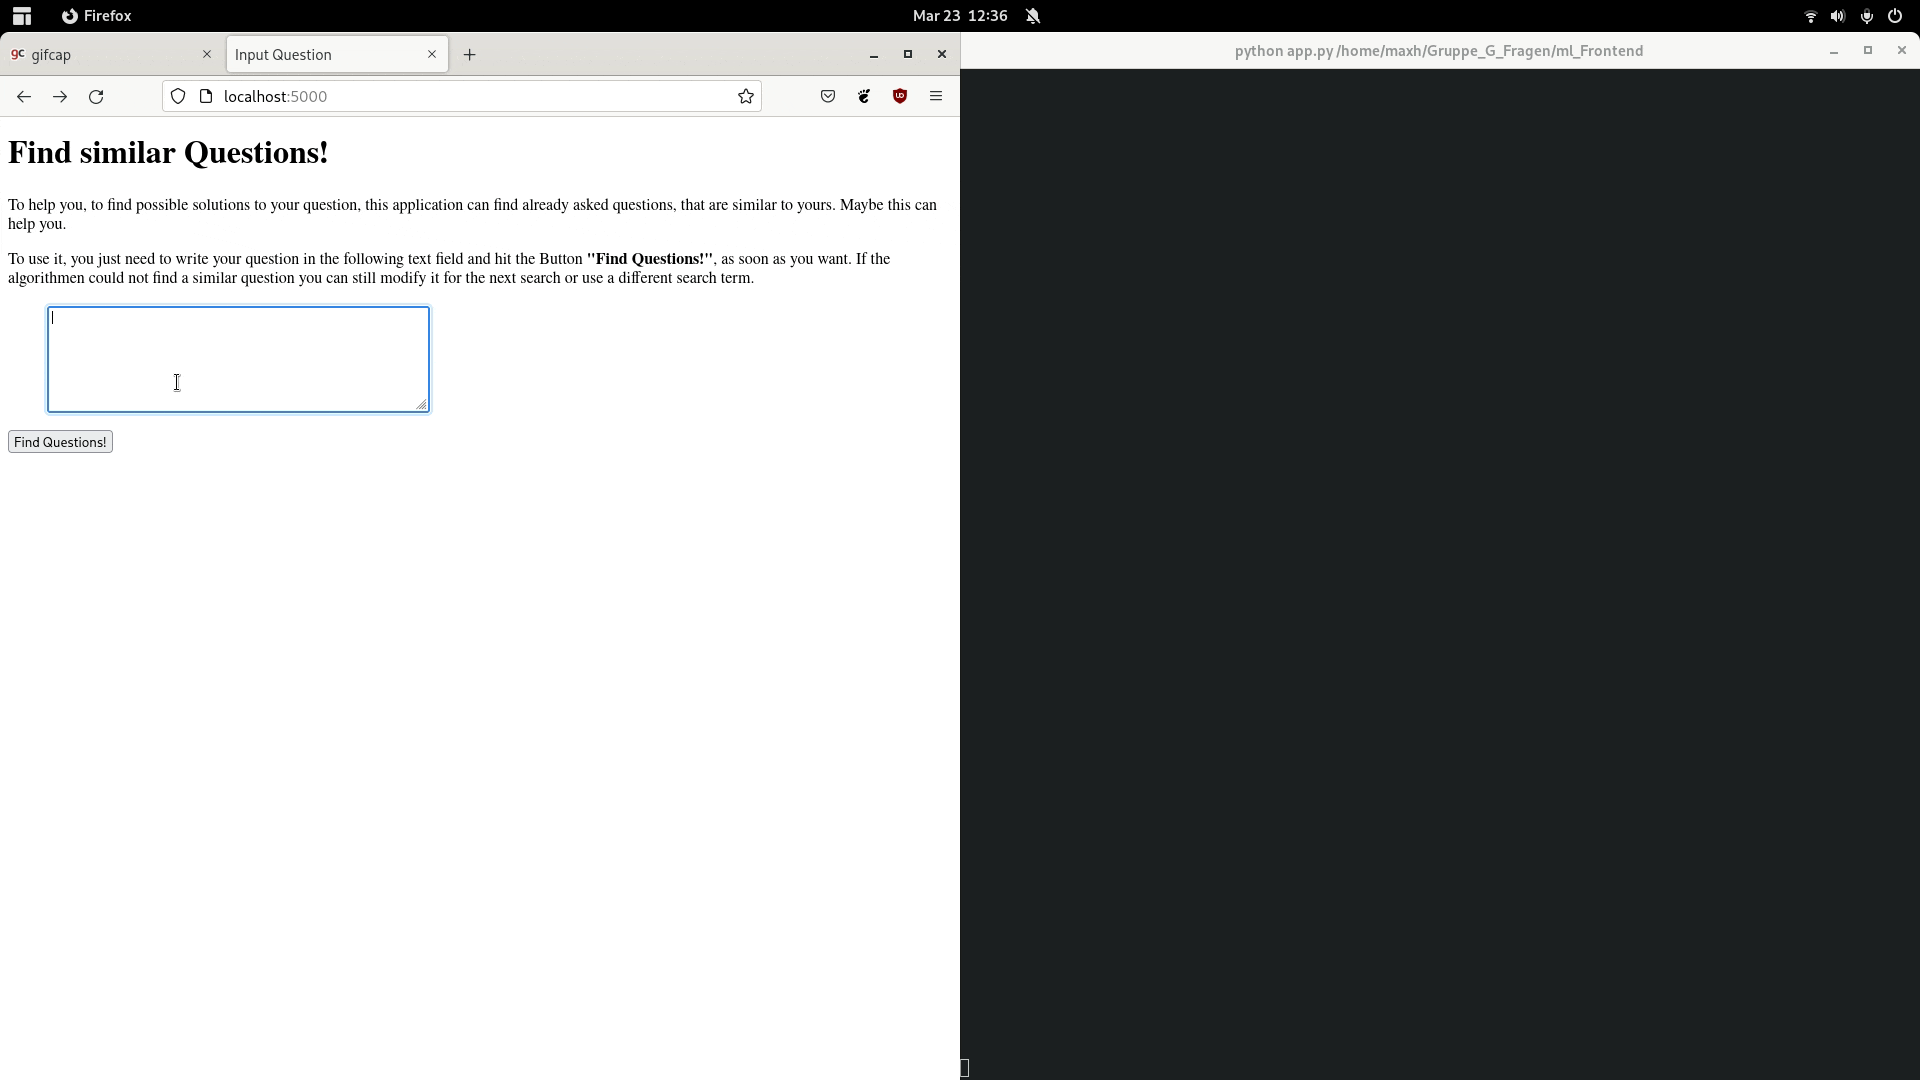

## Trainingsumgebung

Plattform:
- CPU: Ryzen5 1500X
- RAM: 16GB DDR4
- GPU: Nvidia RTX 3060ti 
- OS: Linux, Kernel 5.16  

Dauer:
- 1h 20 min
- 10 min ohne Hyperoptimierer  

## Learnings

- Klassifikation, ob zwei Fragen ausreichend verwandt sind, auch abhängig vom Blick der Person
- Eventuell stimmt nicht bei allen Trainiungs und Testfragen, der is_duplicate Wert



## Ideen für das nächste Mal

- Anhand des gewonnen Modells könnte man einen Text-Gen aufbauen, um mit diesem dann ähnliche Fragen zu detektieren.
- Optimierung der Laufzeit, gerade bei der Vorhersage(ca. 4-5 Sekunden)

## Referenzen

- https://www.tensorflow.org/text/tutorials/text_classification_rnn
- https://www.tensorflow.org/tutorials/keras/keras_tuner
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Multiply
- https://flask.palletsprojects.com/en/2.0.x/
- https://stackoverflow.com/questions/58900947/keras-tensorflow-merge-two-different-model-output-into-one
- https://www.tensorflow.org/text/tutorials/nmt_with_attention
- https://www.tensorflow.org/text/tutorials/text_classification_rnn
- https://github.com/stanfordnlp/GloVe
- 9: Embedding a Machine Learning Model into a Web Application(Unterrichtsmaterialien)

## Saddly to long

## Input-Modell

1. Erstellung eines vorgefertigten GloVe Models für die Embedding Layer
   -> genutzt, um die einzelnen Worte in den Fragen vorzugewichten
2. Eine der folgenden Möglichkeiten kann durch den Hyperoptimierer ausgewählt werden:
   - 2 SimpleRNN Layer
   - 2 LSTM Layer
   - 2 GRU Layer
   - 1 bidirektionale LSTM-Layer
    
3. 2 Dense Layer

Output der zweiten Dense Layer kann Ausgabegrößen von 1-4 besitzen

## "Hauptmodell"

1. erste Layer sind die beiden Inputmodelle
2. Mulitply-Layer
   um beide Outputs zusammenzufügen
3. Flattenlayer
4. 2 malige Verarbeitung mittles Kombination aus Dense- und Dropout Layer
5. Dense Layer mit der Unit-Größe=1 als Abschluss

## Optimierung des Modells

Einsatz des Adam-Optimzers als Optimierer
Einsatz von Hyperband als Hyperoptimiere  
Dafür folgende Optimierungsmöglichkeiten:
- Input-Modell:
    - Einfluss der Gewichte in der Embedding Layer
    - Auswahl der 
    - Entscheidungsvariable zur Anpassung der zwei Dense Layer
- Haupt-Modell:
    - Testen der optimalen Anzahl an Units in den beiden ersten Dense-Layers
      1. Umfang von 100-150
      2. Umfang von 50-100
      
- Wahl der Learning-Rate
    

## Weitere Beispiele im Testdatensatz


Fragen, die beim Hinschauen offentsichtlich nicht zu sinnverwandt sein können:  
- 58,"Why is glass a green in color?","What color say?"
- 122,"Is petroleum a mineral? If weight why?","Why mineral?"
- 129,"What is way?","What card good surrealism from bad surrealism?"
- 138,"Vit vs nirma?","Why do you create a blog?"
- 12,"What if a cricket hits a batsman’s helmet and then goes to the boundary?",Should carbonated red balls and 8 yellow balls. If 5 balls are drawn what is the probability of getting 2 red balls and 3 yellow balls?


Fragen, bei denen es auf den Blick des Users ankommt:
- 151,"How do I hide famous followers?","How can I the identity of a follower on Instagram?"
- 11,"What services are from Google: Facebook, YouTube betray Twitter?", "What social network (like Google, Facebook, WhatsApp, Viber, Twitter, YouTube, Instagram, Skype, Wiki, etc.) made huge impact on people and lifestyles?"

Probleme bei der Grammatik:
- 0,"How does the Surface Pro himself 4 compare with iPad Pro?", "Why did Microsoft choose core m3 and not core i3 home Surface Pro 4?"
- 5,"How are the two wheeler insurance from Bharti Axa insurance?","I admire I am considering of buying insurance from them"